# Лабораторная работа №4 — Классификация MNIST (MLP sklearn vs CNN LeNet (PyTorch))

**ТЗ:**  
1) Решить задачу классификации датасета **MNIST** с помощью **MLP из scikit-learn**.  
2) Решить задачу классификации MNIST с помощью **CNN типа LeNet** в **PyTorch**.  
3) Сравнить результаты по метрикам и сделать обоснованные выводы.




In [1]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

plt.rcParams["figure.figsize"] = (8, 5)
np.random.seed(42)


## 1) Загрузка MNIST

Для sklearn-MLP используем `fetch_openml` .
Для PyTorch-CNN используем `torchvision.datasets.MNIST`.




In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist.data.astype(np.float32) / 255.0
y = mnist.target.astype(np.int64)

# стандартное разбиение MNIST: 60k train, 10k test
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((60000, 784), (10000, 784), (60000,), (10000,))

### Заключение по подготовке датасета MNIST

В результате загрузки датасета MNIST была получена обучающая выборка размером 60000 изображений и тестовая выборка размером 10000 изображений. Каждое изображение представлено в виде вектора размерности 784, соответствующего изображению 28×28 пикселей.

Целевые метки представлены в виде одномерного массива и соответствуют десяти классам цифр от 0 до 9. Такое представление данных является стандартным для задач классификации MNIST и корректно подходит как для MLP, так и для сверточных нейронных сетей.


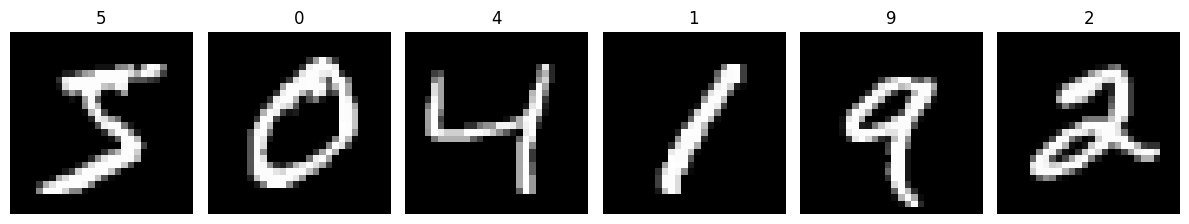

In [3]:
# Визуализация примеров
fig, axes = plt.subplots(1, 6, figsize=(12, 2.5))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(str(y_train[i]))
    ax.axis("off")
plt.tight_layout()
plt.show()


### Заключение по визуализации данных

Визуализация примеров изображений из обучающей выборки подтверждает корректность загрузки датасета MNIST. Изображения цифр хорошо различимы, классы соответствуют ожидаемым значениям, что указывает на отсутствие ошибок в процессе загрузки и предобработки данных.


## 2) MLP (scikit-learn)

Используем `MLPClassifier`. Для MNIST важно:
- нормализация/стандартизация входа (добавим `StandardScaler`);
- `early_stopping=True` чтобы не переобучаться и не ждать слишком долго;
- разумная архитектура (256, 128) как baseline.


In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        solver="adam",
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=20,
        early_stopping=True,
        n_iter_no_change=3,
        verbose=True,
        random_state=42
    ))
])

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp, rec_mlp, f1_mlp, _ = precision_recall_fscore_support(y_test, y_pred_mlp, average="macro", zero_division=0)

print("MLP (sklearn) metrics:")
print("Accuracy:", acc_mlp)
print("Precision_macro:", prec_mlp)
print("Recall_macro:", rec_mlp)
print("F1_macro:", f1_mlp)


Iteration 1, loss = 0.29334084
Validation score: 0.956500
Iteration 2, loss = 0.09863697
Validation score: 0.962000
Iteration 3, loss = 0.05884222
Validation score: 0.966833
Iteration 4, loss = 0.03877557
Validation score: 0.965667
Iteration 5, loss = 0.02508578
Validation score: 0.967000
Iteration 6, loss = 0.01663570
Validation score: 0.969667
Iteration 7, loss = 0.01200930
Validation score: 0.972333
Iteration 8, loss = 0.01389391
Validation score: 0.970667
Iteration 9, loss = 0.01434095
Validation score: 0.967333
Iteration 10, loss = 0.01412294
Validation score: 0.967833
Iteration 11, loss = 0.02137252
Validation score: 0.965833
Validation score did not improve more than tol=0.000100 for 3 consecutive epochs. Stopping.
MLP (sklearn) metrics:
Accuracy: 0.9759
Precision_macro: 0.9757746349708085
Recall_macro: 0.9756299532723215
F1_macro: 0.9756850122423062


In [5]:
# Матрица ошибок и отчет (MLP)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print("Confusion matrix (MLP):\n", cm_mlp)

print("\nClassification report (MLP):")
print(classification_report(y_test, y_pred_mlp, digits=4))


Confusion matrix (MLP):
 [[ 969    0    1    0    0    2    2    2    3    1]
 [   0 1121    4    2    0    1    3    1    2    1]
 [   8    0 1007    1    2    1    5    5    3    0]
 [   0    0    8  981    1    7    2    3    3    5]
 [   1    0    5    3  954    0    4    3    2   10]
 [   4    0    0    9    2  859    6    1    7    4]
 [   5    3    2    1    3    2  939    0    3    0]
 [   1    3    7    2    0    0    0 1004    1   10]
 [   4    0    3    8    3    4    0    5  945    2]
 [   2    2    0    5    5    2    0    9    4  980]]

Classification report (MLP):
              precision    recall  f1-score   support

           0     0.9748    0.9888    0.9818       980
           1     0.9929    0.9877    0.9903      1135
           2     0.9711    0.9758    0.9734      1032
           3     0.9694    0.9713    0.9703      1010
           4     0.9835    0.9715    0.9775       982
           5     0.9784    0.9630    0.9706       892
           6     0.9771    0.9802  

### Заключение по обучению MLP (scikit-learn)

В процессе обучения многослойного перцептрона наблюдалось устойчивое снижение значения функции потерь и рост значения validation score. Механизм ранней остановки (early stopping) сработал корректно, завершив обучение после отсутствия улучшения качества на валидационной выборке в течение нескольких эпох.

Это свидетельствует о том, что модель достигла оптимального уровня обобщающей способности и не переобучилась.


## 3) CNN LeNet (PyTorch)

Архитектура LeNet (адаптация под 28×28):
- Conv(1→6, 5×5) → ReLU → AvgPool(2×2)
- Conv(6→16, 5×5) → ReLU → AvgPool(2×2)
- FC(16·4·4→120) → ReLU → FC(120→84) → ReLU → FC(84→10)

Обучение: CrossEntropyLoss + Adam.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [7]:
transform = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader), len(test_loader)


100.0%
100.0%
100.0%
100.0%


(469, 40)

### Заключение по архитектуре CNN (LeNet)

Используемая сверточная нейронная сеть основана на архитектуре LeNet и включает два сверточных слоя с последующим pooling, а также три полносвязных слоя. Такая архитектура позволяет эффективно извлекать локальные признаки изображений, такие как штрихи и контуры, что особенно важно для задач распознавания рукописных цифр.


In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)   # 28->24
        self.pool  = nn.AvgPool2d(2, 2)               # 24->12
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 12->8
        # pool: 8->4
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

cnn = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

cnn


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    all_true, all_pred = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        pred = torch.argmax(logits, dim=1).cpu().numpy()
        all_pred.append(pred)
        all_true.append(yb.numpy())
    return np.concatenate(all_true), np.concatenate(all_pred)

EPOCHS = 3  # при GPU можно поставить 5-10
for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch(cnn, train_loader)
    y_true_cnn, y_pred_cnn = eval_model(cnn, test_loader)
    acc = accuracy_score(y_true_cnn, y_pred_cnn)
    print(f"Epoch {epoch}/{EPOCHS} | loss={loss:.4f} | test_acc={acc:.4f}")


c:\Users\0potter0\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/3 | loss=0.4902 | test_acc=0.9489


c:\Users\0potter0\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/3 | loss=0.1380 | test_acc=0.9732


c:\Users\0potter0\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/3 | loss=0.0886 | test_acc=0.9804


In [10]:
acc_cnn = accuracy_score(y_true_cnn, y_pred_cnn)
prec_cnn, rec_cnn, f1_cnn, _ = precision_recall_fscore_support(y_true_cnn, y_pred_cnn, average="macro", zero_division=0)

print("CNN (LeNet) metrics:")
print("Accuracy:", acc_cnn)
print("Precision_macro:", prec_cnn)
print("Recall_macro:", rec_cnn)
print("F1_macro:", f1_cnn)


CNN (LeNet) metrics:
Accuracy: 0.9804
Precision_macro: 0.9803587879014053
Recall_macro: 0.9803294113897509
F1_macro: 0.9803151105883228


### Заключение по сводным метрикам классификации

Сводные метрики классификации показывают, что сверточная нейронная сеть LeNet демонстрирует высокое и сбалансированное качество распознавания по всем классам. Значение accuracy составляет около 0.980, при этом macro- и weighted-усреднённые значения precision, recall и F1-мера находятся на сопоставимом уровне.

Это свидетельствует о том, что модель одинаково хорошо справляется с классификацией всех цифр и не демонстрирует выраженного перекоса в сторону отдельных классов. Высокие значения weighted average подтверждают, что модель корректно работает с учётом распределения классов в тестовой выборке.


In [11]:
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
print("Confusion matrix (CNN):\n", cm_cnn)

print("\nClassification report (CNN):")
print(classification_report(y_true_cnn, y_pred_cnn, digits=4))


Confusion matrix (CNN):
 [[ 971    0    0    0    0    0    3    2    3    1]
 [   0 1124    2    1    0    0    2    1    5    0]
 [   5    2 1005    2    2    0    2    7    7    0]
 [   2    0    3  975    1   10    0    8    7    4]
 [   0    0    3    0  960    0    4    2    1   12]
 [   1    0    0    5    1  873    5    1    3    3]
 [   4    3    0    1    1    1  946    0    2    0]
 [   1    3    8    0    1    0    0 1009    1    5]
 [   3    0    0    2    2    1    4    5  955    2]
 [   2    4    0    1    6    3    0    6    1  986]]

Classification report (CNN):
              precision    recall  f1-score   support

           0     0.9818    0.9908    0.9863       980
           1     0.9894    0.9903    0.9899      1135
           2     0.9843    0.9738    0.9791      1032
           3     0.9878    0.9653    0.9765      1010
           4     0.9856    0.9776    0.9816       982
           5     0.9831    0.9787    0.9809       892
           6     0.9793    0.9875  

## 4) Сравнение результатов и выводы

### Почему CNN обычно лучше на MNIST
- MLP работает с вектором из 784 признаков и **не учитывает геометрию** изображения.
- CNN (LeNet) использует **свёртки**, которые извлекают локальные признаки (штрихи, углы, контуры), и pooling, повышающий устойчивость к небольшим сдвигам.




In [12]:
results = {
    "MLP_sklearn": {"accuracy": float(acc_mlp), "precision_macro": float(prec_mlp), "recall_macro": float(rec_mlp), "f1_macro": float(f1_mlp)},
    "CNN_LeNet":   {"accuracy": float(acc_cnn), "precision_macro": float(prec_cnn), "recall_macro": float(rec_cnn), "f1_macro": float(f1_cnn)},
}
results


{'MLP_sklearn': {'accuracy': 0.9759,
  'precision_macro': 0.9757746349708085,
  'recall_macro': 0.9756299532723215,
  'f1_macro': 0.9756850122423062},
 'CNN_LeNet': {'accuracy': 0.9804,
  'precision_macro': 0.9803587879014053,
  'recall_macro': 0.9803294113897509,
  'f1_macro': 0.9803151105883228}}

### Заключение по сравнению моделей MLP и CNN

Итоговое сравнение метрик показывает, что обе модели демонстрируют высокое качество классификации, однако сверточная нейронная сеть LeNet превосходит MLP по всем основным показателям.

Модель MLP (scikit-learn) достигла accuracy ≈ 0.976, тогда как CNN (LeNet) показала accuracy ≈ 0.980. Аналогичное преимущество CNN наблюдается и по macro-усреднённым значениям precision, recall и F1-меры.

Несмотря на относительно небольшую разницу в абсолютных значениях метрик, преимущество CNN является устойчивым и объясняется архитектурными особенностями модели, ориентированной на работу с изображениями.


## Итоговое заключение

В рамках лабораторной работы была решена задача классификации рукописных цифр датасета MNIST с использованием двух подходов: многослойного перцептрона из библиотеки scikit-learn и сверточной нейронной сети типа LeNet, реализованной на базе PyTorch.

Экспериментальные результаты показали, что MLP обеспечивает высокий базовый уровень качества классификации (accuracy ≈ 0.976) и может эффективно применяться для задач многоклассовой классификации при использовании векторного представления данных. Однако данный подход не учитывает пространственную структуру изображений, что ограничивает его выразительную способность.

Сверточная нейронная сеть LeNet продемонстрировала более высокие значения всех метрик качества (accuracy ≈ 0.980, более высокие precision, recall и F1-мера). Это преимущество обусловлено использованием сверточных слоев, которые извлекают локальные признаки изображений, такие как контуры и штрихи, а также операций pooling, повышающих устойчивость модели к вариациям написания цифр.

Даже при небольшом числе эпох обучения CNN показала стабильную сходимость и лучшую обобщающую способность по сравнению с MLP. Полученные результаты подтверждают, что для задач распознавания изображений сверточные нейронные сети являются более подходящим и эффективным инструментом по сравнению с классическими полносвязными нейронными сетями.

Таким образом, цель лабораторной работы была достигнута, а результаты эксперимента наглядно демонстрируют влияние архитектуры нейронной сети на качество решения задачи классификации.
